In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
from prophet import Prophet

# Load the dataset
df = pd.read_excel('../Godzilla.xlsx')

# Convert release date to datetime
df['Release Date'] = pd.to_datetime(df['Release Date'])

# Extract the release year
df['Release Year'] = df['Release Date'].dt.year

# Convert the 'Movie Budget (Yen)' and 'Final Revenue (Yen)' columns to numeric values, removing any non-numeric characters
df['Movie Budget (Yen)'] = df['Movie Budget (Yen)'].replace('[\¥,\,]', '', regex=True).replace('-', np.nan).astype(float)
df['Final Revenue (Yen)'] = df['Final Revenue (Yen)'].replace('[\¥,\,]', '', regex=True).replace('-', np.nan).astype(float)


# Convert Yen to USD (1 USD = 140 JPY)
conversion_rate = 140
df['Movie Budget (USD)'] = df['Movie Budget (Yen)'] / conversion_rate
df['Final Revenue (USD)'] = df['Final Revenue (Yen)'] / conversion_rate

# Drop the Yen columns as we are using the USD columns for modeling
df = df.drop(columns=['Movie Budget (Yen)', 'Final Revenue (Yen)', 'Position', 'URL', 'Japanese Title'])

# Fill missing values in 'Movie Budget (USD)' column with the mean value within each era
df['Movie Budget (USD)'] = df.groupby('Era')['Movie Budget (USD)'].transform(lambda x: x.fillna(x.mean()))


In [28]:
pd.options.display.float_format = '{:.2f}'.format
df.tail()

,English Title,IMDb Rating,Rotten Tomatoes Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Godzilla's Sizes (In Feet),Godzilla's Sizes (In Meters),Era,Number of Monsters,Tickets Sold,Release Year,Movie Budget (USD),Final Revenue (USD)
31,Godzilla: Planet of the Monsters,6.00,0.71,89,2017,"Animation, Action, Adventure, Sci-Fi",8612,2017-11-17,"Hiroyuki Seshita, Kôbun Shizuno",984,300,Reiwa,1,260000,2017,2428571.43,2428571.43
32,Godzilla: City on the Edge of Battle,5.80,0.60,101,2018,"Animation, Action, Adventure, Sci-Fi",4939,2018-05-18,"Hiroyuki Seshita, Kôbun Shizuno",984,300,Reiwa,2,73000,2018,1071428.57,1071428.57
33,Godzilla: The Planet Eater,5.00,0.60,91,2018,"Animation, Action, Adventure, Sci-Fi",4236,2018-11-03,"Hiroyuki Seshita, Kôbun Shizuno",984,300,Reiwa,2,130000,2018,1071428.57,1071428.57
34,Godzilla: King of the Monsters,6.00,0.42,132,2019,"Action, Adventure, Fantasy, Sci-Fi",180275,2019-05-29,Michael Dougherty,394,120,Monsterverse,4,12264200,2019,173592150.00,109478171.43
35,Godzilla vs. Kong,6.30,0.75,113,2021,"Action, Sci-Fi, Thriller",203491,2021-03-24,Adam Wingard,394,120,Monsterverse,3,10732000,2021,153169542.86,99969828.57


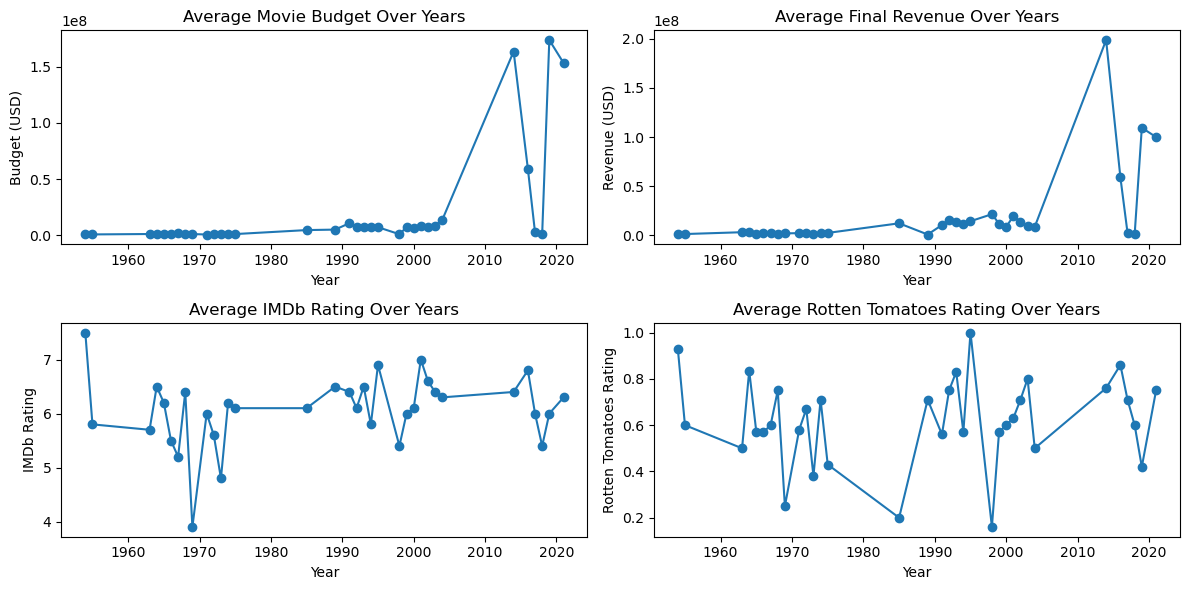

In [29]:
# Aggregate data by release year
yearly_data = df.groupby('Release Year').agg({
    'Movie Budget (USD)': 'mean',
    'Final Revenue (USD)': 'mean',
    'IMDb Rating': 'mean',
    'Rotten Tomatoes Rating': 'mean'
}).reset_index()

# Plot trends
plt.figure(figsize=(12, 6))

# Budget trend
plt.subplot(2, 2, 1)
plt.plot(yearly_data['Release Year'], yearly_data['Movie Budget (USD)'], marker='o')
plt.title('Average Movie Budget Over Years')
plt.xlabel('Year')
plt.ylabel('Budget (USD)')

# Revenue trend
plt.subplot(2, 2, 2)
plt.plot(yearly_data['Release Year'], yearly_data['Final Revenue (USD)'], marker='o')
plt.title('Average Final Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Revenue (USD)')

# IMDb rating trend
plt.subplot(2, 2, 3)
plt.plot(yearly_data['Release Year'], yearly_data['IMDb Rating'], marker='o')
plt.title('Average IMDb Rating Over Years')
plt.xlabel('Year')
plt.ylabel('IMDb Rating')

# Rotten Tomatoes rating trend
plt.subplot(2, 2, 4)
plt.plot(yearly_data['Release Year'], yearly_data['Rotten Tomatoes Rating'], marker='o')
plt.title('Average Rotten Tomatoes Rating Over Years')
plt.xlabel('Year')
plt.ylabel('Rotten Tomatoes Rating')

plt.tight_layout()
plt.show()

In [30]:
# Prepare data for Prophet
prophet_data = df[['Release Date', 'Final Revenue (USD)']]
prophet_data.columns = ['ds', 'y']

# Initialize and fit the model
model = Prophet()
model.fit(prophet_data)

# Save the model to a pickle file
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)

16:04:04 - cmdstanpy - INFO - Chain [1] start processing
16:04:04 - cmdstanpy - INFO - Chain [1] done processing
